In [1]:
# Install packages
!pip install SciencePlots pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb tifffile --upgrade
!sudo apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super > /dev/null
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install optax==0.1.8
#!pip install nvidia-cublas-cu12 nvidia-cuda-nvcc-cu12 nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12 nvidia-cufft-cu12 nvidia-cusolver-cu12 nvidia-cusparse-cu12
#!pip install -U https://storage.googleapis.com/jax-releases/cuda12/jaxlib-0.4.23+cuda12.cudnn89-cp310-cp310-manylinux2014_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2024.4.24
    Uninstalling tifffile-2024.4.24:
      Successfully uninstalled tifffile-2024.4.24
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, s

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

#import optax  # WARNING: Optax depends on Chex and Chex does not work with the newest JAX

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
#import pennylane as qml
#import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile

import scienceplots

plt.style.use(['science','nature'])

%matplotlib inline

from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

#sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
#prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

cpu
Set platform to CPU


In [3]:
base_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/"

digits = "sklearn-digits-dataset"
minst = "mnist"
fashionmnist = "fashion-mnist"
ctimg = "ct-med-img"

digitsbaseline = "digits_baseline_results.csv"
digitsHerm = "digits_HermImgReUpload_results.csv"

mnistbaseline = "mnist_baseline_results.csv"
mnistHerm = "mnist_HermImgReUpload_results.csv"

fashionmnistbaseline = "fashion-mnist_baseline_results.csv"
fashionmnistHerm = "fashion-mnist_HermImgReUpload_results.csv"
fashionmnistHerm2x = "fashion-mnist_HermImgReUpload20Reps_results.csv"

ctimgbaseline = "ct-med-img_baseline_results.csv"
ctimgHerm = "ct-med-img_HermReUpload_results.csv"

In [4]:
digits_df = {
    "baseline":pd.read_csv(os.path.join(base_folder, digits, digitsbaseline)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index(),
    "HermImgReUpload":pd.read_csv(os.path.join(base_folder, digits, digitsHerm)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()
}

mnist_df = {
    "baseline":pd.read_csv(os.path.join(base_folder, minst, mnistbaseline)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index(),
    "HermImgReUpload":pd.read_csv(os.path.join(base_folder, minst, mnistHerm)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()
}

fashionmnist_df = {
    "baseline":pd.read_csv(os.path.join(base_folder, fashionmnist, fashionmnistbaseline)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index(),
    "HermImgReUpload":pd.read_csv(os.path.join(base_folder, fashionmnist, fashionmnistHerm)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index(),
    "HermImgReUpload2x":pd.read_csv(os.path.join(base_folder, fashionmnist, fashionmnistHerm2x)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()
}

ctimg_df = {
    "baseline":pd.read_csv(os.path.join(base_folder, ctimg, ctimgbaseline)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index(),
    "HermImgReUpload":pd.read_csv(os.path.join(base_folder, ctimg, ctimgHerm)).groupby(["n_train", "step"]).agg(["mean", "std"]).reset_index()
}

In [5]:
digits_df["baseline"]

n_train step Unnamed: 0              train_acc           train_cost  \
                       mean          std      mean       std       mean   
0      1200    1     4750.0  2958.039892  0.239208  0.083081   2.080337   
1      1200    2     4751.0  2958.039892  0.315083  0.072203   2.057280   
2      1200    3     4752.0  2958.039892  0.333958  0.077380   2.045028   
3      1200    4     4753.0  2958.039892  0.392375  0.081347   2.037067   
4      1200    5     4754.0  2958.039892  0.447917  0.097470   2.030592   
..      ...  ...        ...          ...       ...       ...        ...   
495    1200  496     5245.0  2958.039892  0.798583  0.052082   1.945976   
496    1200  497     5246.0  2958.039892  0.800083  0.050984   1.945935   
497    1200  498     5247.0  2958.039892  0.798083  0.052406   1.945952   
498    1200  499     5248.0  2958.039892  0.799750  0.050393   1.946041   
499    1200  500     5249.0  2958.039892  0.797708  0.054657   1.946144   

              test_acc           test_cost            
          std     mean       std      mean       std  
0    0.009488   0.2340  0.089994  2.057466  0.010796  
1    0.009227   0.3260  0.086900  2.044421  0.010884  
2    0.008293   0.3480  0.096932  2.035870  0.011539  
3    0.008487   0.4055  0.092479  2.029523  0.010152  
4    0.007760   0.4515  0.101425  2.023961  0.009375  
..        ...      ...       ...       ...       ...  
495  0.006952   0.7915  0.082925  1.949023  0.008420  
496  0.007003   0.7970  0.077941  1.948906  0.008364  
497  0.007026   0.7895  0.085315  1.949139  0.008515  
498  0.006956   0.7970  0.076784  1.949024  0.008374  
499  0.006879   0.7895  0.091218  1.949298  0.008701  

[500 rows x 12 columns]

Plot the results from the digits dataset

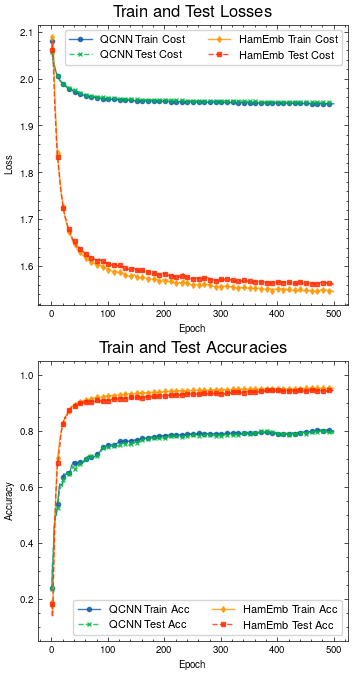

In [6]:
# Plot the results from the digits dataset
#sns.set_style('whitegrid')
#colors = sns.color_palette()
fig, axes = plt.subplots(nrows=2, figsize=(4,8))

n_train = 1200

lines = ["o-", "x--", "o-", "x--"]


# baseline
dfs_baseline = [
    digits_df["baseline"].train_cost["mean"],
    digits_df["baseline"].test_cost["mean"],
    digits_df["baseline"].train_acc["mean"],
    digits_df["baseline"].test_acc["mean"]
    ]
labels = ["QCNN Train Cost", "QCNN Test Cost", "QCNN Train Acc", "QCNN Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      digits_df["baseline"].step,
      dfs_baseline[k],
      lines[k],
      label=labels[k],
      #color=colors[k],
      alpha = 0.8,
      markevery=10
  )

# HamEmb
lines = ["d-", "s--", "d-", "s--"]
dfs_ham = [
    digits_df["HermImgReUpload"].train_cost["mean"],
    digits_df["HermImgReUpload"].test_cost["mean"],
    digits_df["HermImgReUpload"].train_acc["mean"],
    digits_df["HermImgReUpload"].test_acc["mean"]
]
labels = ["HamEmb Train Cost", "HamEmb Test Cost", "HamEmb Train Acc", "HamEmb Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      digits_df["HermImgReUpload"].step,
      dfs_ham[k],
      lines[k],
      label=labels[k],
      #color=colors[-k],
      alpha = 0.8,
      markevery=10
  )

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=12)
ax.set_xlabel('Epoch',)
ax.set_ylabel('Loss',)

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=12)
ax.set_xlabel('Epoch',)
ax.set_ylabel('Accuracy',)
ax.set_ylim(0.05, 1.05)
axes[0].legend(ncol=2, frameon=True, prop={'size': 8})
axes[1].legend(ncol=2, frameon=True, prop={'size': 8})
plt.show()

In [7]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/"
# save the plot to file
fig.savefig(os.path.join(save_folder, "digits_all_results.pdf"))

Plot the results from the MNIST dataset

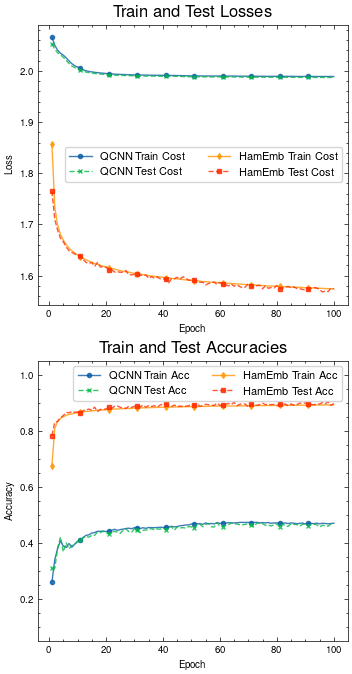

In [8]:
# Plot the results from the mnist dataset
#sns.set_style('whitegrid')
#colors = sns.color_palette()
fig, axes = plt.subplots(nrows=2, figsize=(4,8))


lines = ["o-", "x--", "o-", "x--"]

df = mnist_df

# baseline
dfs_baseline = [
    df["baseline"].train_cost["mean"],
    df["baseline"].test_cost["mean"],
    df["baseline"].train_acc["mean"],
    df["baseline"].test_acc["mean"]
    ]
labels = ["QCNN Train Cost", "QCNN Test Cost", "QCNN Train Acc", "QCNN Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["baseline"].step,
      dfs_baseline[k],
      lines[k],
      label=labels[k],
      #color=colors[k],
      alpha = 0.8,
      markevery=10
  )

# HamEmb
lines = ["d-", "s--", "d-", "s--"]
dfs_ham = [
    df["HermImgReUpload"].train_cost["mean"],
    df["HermImgReUpload"].test_cost["mean"],
    df["HermImgReUpload"].train_acc["mean"],
    df["HermImgReUpload"].test_acc["mean"]
]
labels = ["HamEmb Train Cost", "HamEmb Test Cost", "HamEmb Train Acc", "HamEmb Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["HermImgReUpload"].step,
      dfs_ham[k],
      lines[k],
      label=labels[k],
      #color=colors[-k],
      alpha = 0.8,
      markevery=10
  )

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)
axes[0].legend(ncol=2, frameon=True, prop={'size': 8})
axes[1].legend(ncol=2, frameon=True, prop={'size': 8})
plt.show()

In [9]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/"
# save the plot to file
fig.savefig(os.path.join(save_folder, "mnist_all_results.pdf"))

Plot the FashionMNIST results.


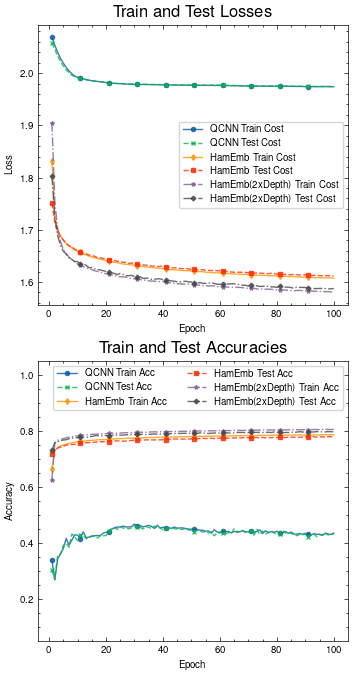

In [10]:
#sns.set_style('whitegrid')
#colors = sns.color_palette()
fig, axes = plt.subplots(nrows=2, figsize=(4,8))


lines = ["o-", "x--", "o-", "x--"]

df = fashionmnist_df

# baseline
dfs_baseline = [
    df["baseline"].train_cost["mean"],
    df["baseline"].test_cost["mean"],
    df["baseline"].train_acc["mean"],
    df["baseline"].test_acc["mean"]
    ]
labels = ["QCNN Train Cost", "QCNN Test Cost", "QCNN Train Acc", "QCNN Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["baseline"].step,
      dfs_baseline[k],
      lines[k],
      label=labels[k],
      #color=colors[k],
      alpha = 0.8,
      markevery=10
  )

# HamEmb
lines = ["d-", "s--", "d-", "s--"]
dfs_ham = [
    df["HermImgReUpload"].train_cost["mean"],
    df["HermImgReUpload"].test_cost["mean"],
    df["HermImgReUpload"].train_acc["mean"],
    df["HermImgReUpload"].test_acc["mean"]
]
labels = ["HamEmb Train Cost", "HamEmb Test Cost", "HamEmb Train Acc", "HamEmb Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["HermImgReUpload"].step,
      dfs_ham[k],
      lines[k],
      label=labels[k],
      #color=colors[-k],
      alpha = 0.8,
      markevery=10
  )

# HamEmb 2xdepth
lines = ["*-.", "P-.", "*-.", "P-."]
dfs_ham = [
    df["HermImgReUpload2x"].train_cost["mean"],
    df["HermImgReUpload2x"].test_cost["mean"],
    df["HermImgReUpload2x"].train_acc["mean"],
    df["HermImgReUpload2x"].test_acc["mean"]
]
labels = ["HamEmb(2xDepth) Train Cost", "HamEmb(2xDepth) Test Cost", "HamEmb(2xDepth) Train Acc", "HamEmb(2xDepth) Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["HermImgReUpload2x"].step,
      dfs_ham[k],
      lines[k],
      label=labels[k],
      #color=colors[4+k],
      alpha = 0.8,
      markevery=10
  )

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)
axes[0].legend(ncol=1, frameon=True, prop={'size': 7})
axes[1].legend(ncol=2, frameon=True, prop={'size': 7})
plt.show()

In [11]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/"
# save the plot to file
fig.savefig(os.path.join(save_folder, "fashionmnist_all_results.pdf"))

Plot the results from the CT medical images

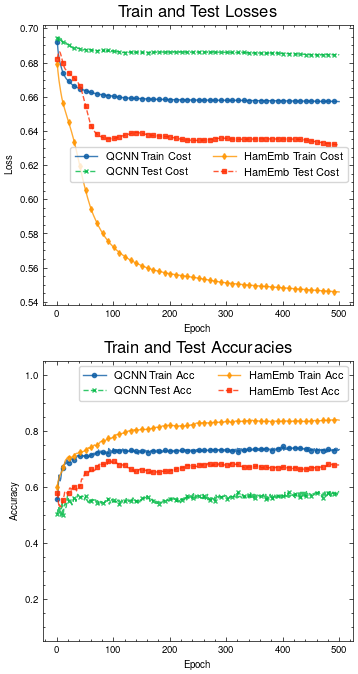

In [15]:
#sns.set_style('whitegrid')
#colors = sns.color_palette()
fig, axes = plt.subplots(nrows=2, figsize=(4,8))


lines = ["o-", "x--", "o-", "x--"]

df = ctimg_df

# baseline
dfs_baseline = [
    df["baseline"].train_cost["mean"],
    df["baseline"].test_cost["mean"],
    df["baseline"].train_acc["mean"],
    df["baseline"].test_acc["mean"]
    ]
labels = ["QCNN Train Cost", "QCNN Test Cost", "QCNN Train Acc", "QCNN Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["baseline"].step,
      dfs_baseline[k],
      lines[k],
      label=labels[k],
      #color=colors[k],
      alpha = 0.8,
      markevery=10
  )

# HamEmb
lines = ["d-", "s--", "d-", "s--"]
dfs_ham = [
    df["HermImgReUpload"].train_cost["mean"],
    df["HermImgReUpload"].test_cost["mean"],
    df["HermImgReUpload"].train_acc["mean"],
    df["HermImgReUpload"].test_acc["mean"]
]
labels = ["HamEmb Train Cost", "HamEmb Test Cost", "HamEmb Train Acc", "HamEmb Test Acc"]
axs = [0,0,1,1]
for k in range(4):
  ax = axes[axs[k]]
  ax.plot(
      df["HermImgReUpload"].step,
      dfs_ham[k],
      lines[k],
      label=labels[k],
      #color=colors[-k],
      alpha = 0.8,
      markevery=10
  )

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)
axes[0].legend(ncol=2, frameon=True, prop={'size': 8})
axes[1].legend(ncol=2, frameon=True, prop={'size': 8})
plt.show()

In [16]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/"
# save the plot to file
fig.savefig(os.path.join(save_folder, "ctimg_all_results.pdf"))